# Lecture 18 - Application of Gaussian Process Regression: Optimizing Expensive Black-box Functions

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import GPy
import numpy as np
import scipy.stats as stats
import numpy as np
from ipywidgets import interactive, interact_manual

## Objectives

+ Optimize an expensive black-box function under a limited budget.
+ Quantify the value of the information extracted from an experiment/simulation.
+ Quantify epistemic uncertainty in location of maximum.
+ Generalize to a nosy expensive black-box function.

## Readings

+ [A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning](https://arxiv.org/abs/1012.2599).


## Baysian Global Optimization of a Scalar Function without Noise

We are going to addresss the problem:
$$
\mathbf{x}^* = \arg\max_{\mathbf{x}}f(\mathbf{x}).
$$
under the assumption that:
+ we can evaluate $f(\mathbf{x})$ at any $\mathbf{x}$;
+ evaluating $f(\mathbf{x})$ takes a lot of time/money;
+ we cannot evaluate the gradient $\nabla f(\mathbf{x})$;
+ the dimensionality of $\mathbf{x}$ is not very high.

Why is this an important problem?
Well, $\mathbf{f}(\mathbf{x})$ may be a very expensive simulation that you would like to optimize under a limitted budget.
It could also be an experimentally measured quantity of interest, but you would have to make sure that the noise is not very big.
We will see what you can do when you have noise later.

### Sequential Information Acquisition for Optimization

What do we mean by *sequential information acquisiton* for optimization?
It is just an algorithm that tells us where to evaluate a function next if we would like to find its maximum/minimum.
The problem can be formulated in a rigorous mathematical way using the theory and tools of dynamic programming.
However, the full fledged mathematical problem of designing optimal evaluation policies tends to be harder than the original problem of just maximizing a function.
So, we usually resort to heurestics.
These heuristics are not optimal in a mathematical sense, but they are convenient in a practical sense.
In a way, the heuristics strike a balance the theoretically optimal (but computationally intractable) thing to do, and just randomly selecting evaluations.

A generic heuristic, which we are going to call "one-step-look ahead information acquisition policy" works as follows:
+ We start with an initial data set consiting of $n_0$ input-output observations:
$$
\mathcal{D}_{n_0} = \left(\mathbf{x}_{1:n_0}, \mathbf{y}_{1:n_0}\right).
$$
For example, one may obtain these through Latin Hypercube Sampling of their input space.
+ For $n=n_0,n_0+1,\dots$, we start do the following:
    - We use the current dataset to quantify our state of knowledge about $f(\mathbf{x})$.
    For example, we can use Gaussian process regression (GPR) or any other Bayesian regression method to obtain the predictive distribution:
        $$
        f(\cdot) | \mathcal{D}_{n_0} \sim p(f(\cdot)|\mathcal{D}_{n_0}).
        $$
    - Then we pick the *most important* point to evaluate next by looking at maximizing an *acquisition function*
    $a_{n_0}(\mathbf{x})$ which depends on our current state of knowledge (we will see specific examples below).
    This acquisition function quantifies, for example, how much value or how much information there is in
    in doing an evaluation at $\mathbf{x}$.
    We can assume that it is a nonnegative function.
    So, we to pick the next point we solve a problem of the form:
    $$
    \mathbf{x}_{n+1} = \arg\max a_{n}(\mathbf{x}).
    $$
    That is, we pick the point with the maximum value or the maximum information.
    - If maximum value of the acquisition function is smaller than a threshold, e.g., if $a_n(\mathbf{x}) \le \epsilon$ for some $\epsilon > 0$, then we STOP.
    - Otheweise, we evaluate the function at the selected $\mathbf{x}_{n+1}$ to obtain:
    $$
    y_n = f(\mathbf{x}_n).
    $$
    This would entain either running a simulation or doing an experiment.
    - We augment our original data set with the new observation:
    $$
    \mathcal{D}_{n+1} = \left((\mathbf{x}_{1:n},\mathbf{x}_n), (\mathbf{y}_{1:n},y_n)\right).
    $$
    - We use Bayes' rule to update our state of knowledge:
    $$
    f(\cdot)|\mathcal{D}_{n+1} \sim p(f(\cdot)|\mathcal{D}_{n+1}) \propto p(y_{n+1}|x_{n+1}, f(\cdot))p(f(\cdot)|\mathcal{D}_{n}).
    $$
    - If we have run out of evaluation budget, we STOP. Otherwise, we continue the loop.
+ At this point, we report our current state of knowledge about the maximum of the function.
For example, we can report what is the *observed maximum*.
That is, we can find the index of the evaluation corresponding to the observed maximum:
$$
i^* = \arg\max_{1\le i\le n} y_i,
$$
and say that the maximum was $y_{i^*}$ and the location of the maximum is $\mathbf{x}_{i^*}$.
Alternatively, and in particular if our optimizatioin budget is low, we can also quantify our epistemic uncertainty about the location of the maximum. We discuss this idea in detail towards the end of this notebook.


## Working 1D Example

It is easier to introduce the ideas using an example.
Let's work with a synthetic 1D function defined in $[0,1]$:

Text(0, 0.5, '$y$')

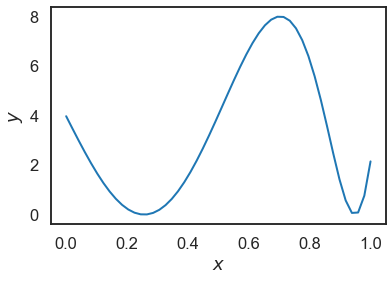

In [2]:
def f(x):
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

x = np.linspace(0, 1)
plt.plot(x, f(x), linewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$')

We wish to maximize this function (of course, in reality, you wouldn't see the functioin).
Let us generate some starting data:

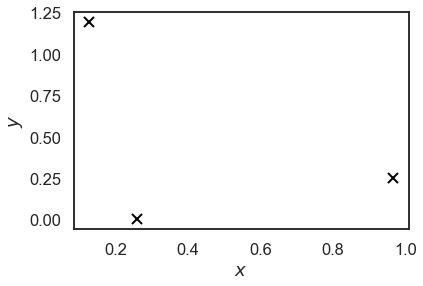

In [3]:
np.random.seed(123456) # For reproducibility
n_init = 3
X = np.random.rand(n_init) # In 1D you don't have to use LHS
Y = f(X)
plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$');

Assume that we do some kind of Bayesian regression, using the data we have so far.
Here, we will do GPR, but any Bayesian regression would actually work.
We will not work right now with the full predictive $p(f(\cdot)|\mathcal{D}_{n})$, but with the point-predictive distribution:
$$
p(y|\mathbf{x},\mathcal{D}_{n}) = \mathcal{N}\left(y|m_{n}(\mathbf{x}), \sigma^2_{n}(\mathbf{x})\right),
$$
where $m_{n}(\mathbf{x})$ and $\sigma^2_{n}(\mathbf{x})$ are the predictive mean and variance respectively.

Here is an example with GPR:

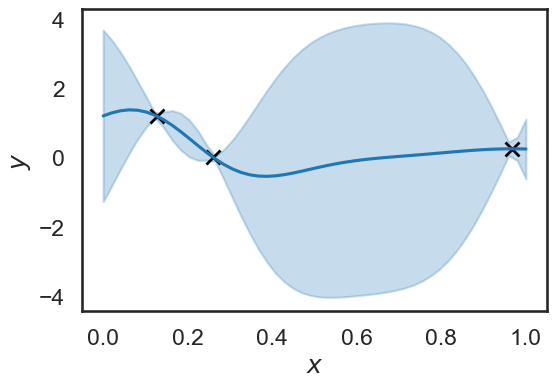

In [4]:
# The kernel we use
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
# Assuming that we know there is no measurement noise:
gpr.likelihood.variance.constrain_fixed(1e-16)
# You can evaluate the predictive distribution anywhere:
m, sigma2 = gpr.predict(x[:, None])
# And you can visualize the results as follows
# Standard deviation
sigma = np.sqrt(sigma2)
# Lower quantile
l = m - 1.96 * sigma
u = m + 1.96 * sigma
fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x, m)
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25);

Now, the question is this: "Where should we evaluate the function next if our goal is to maximize the function?"
Two possibilities of choosing a point for the next evaluation are:
+ **Exploitation:** We can choose a point $\mathbf{x}$ that *exploits* our current state of knowledge by concentrating on the region where the model thinks the maximum is. In our working example, that would be the point right next to the left most observation.
+ **Explortation:** We can *explore* the regions of maximum predictive uncertainty because there is a high chance that they may hide the maximum of the function. In our working example, this is the region between the two observations on the right.

Generally speaking, it is a very bad idea to focus exclusive on either on exploration or exploitation.
On one hand, if we focus on exploration, then we will at the end recover the true response surface (and as a consequence we will get the correct maximum of the function) but we waste a lot of evaluations on regions that are very unlikely to contain the maximum.
If on the other hand we focus on exploitation, then we will very quickly converge to a local maximum, maybe a good one maybe a bad one, and a lot of the input space will remain unexplored.

So, what should a good *information acquisition function* $a_n(\mathbf{x})$ for optimization do?
It should *strike a balance between exploration and exploitation* in a way that provably reveals, in the limit of large number of evaluations, the global maximum of the function.
Are there such information acquisition algorithms? Yes there are.
Let's explore some ideas.

## Maximum upper interval

The maximum upper interval is defined to be:
$$
a_n(\mathbf{x}) = \mu_n(\mathbf{x}) + \psi \sigma_n(\mathbf{x}),
$$
for some $\psi \ge 0$.
Note that here we are using the predictive mean and variance.
The parametr $\psi$ controls how much emphasis you put on exploitation and exploration.
The choice $\psi = 0$ is full-on exploitation. You are just looking at the predictive mean.
The greater $\psi$ is, the more emphasis you put on the predictive standard deviation, i.e., the more you try to explore.
There is an implementation:

In [5]:
def mui(m, sigma, ymax, psi=1.96):
    return m + psi * sigma

Let's visualize this:

In [6]:
def plot_mui(psi=0.):
    fig, ax = plt.subplots(dpi=100)
    ax.set_title('$\psi={0:1.2f}$'.format(psi))
    ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.plot(x, m)
    ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
    af_values = mui(m, sigma, Y.max(), psi)
    next_id = np.argmax(af_values)
    next_x = x[next_id]
    af_max = af_values[next_id]
    ax2 = ax.twinx()
    ax2.plot(x, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel('Maximum Upper Interval', color=sns.color_palette()[1])
    plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
    ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)

interact_manual(plot_mui, psi=(0., 4., 0.001))

interactive(children=(FloatSlider(value=0.0, description='psi', max=4.0, step=0.001), Button(description='Run …

<function __main__.plot_mui(psi=0.0)>

### Questions
+ Experiment with different values of $\psi$.
+ When do you get exploration?
+ When do you get exploitation?

## Probability of improvement

What if you try to find the point that maximizes the probability of getting an observation greater than the ones you have so far?
Let's derive this.
First, let's call $y_n^*$ the current maximum in your dataset, i.e.,
$$
y_n^* = \max_{1\le i\le n}y_i.
$$
We define the following acquisition function:
$$
a_n(\mathbf{x}) = \mathbb{P}[y > y_n^* + \psi | \mathbf{x}, \mathcal{D}_n].
$$
We read "$a_n(\mathbf{x})$" is the probability that we observe at $x$ a $y$ that is greater than the currently observed maximum $y_n^*$ by at least $\psi>0$.
The good thing is that it is possible to get an analytical answer because our point predictive distribution is Gaussian.
In particular, we get:
$$
\begin{align}
a_n(\mathbf{x}) &=& \mathbb{P}[y > y_n^* + \psi | x, \mathcal{D}_n]\\
&=& \mathbb{P}\left[\frac{y - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} > \frac{y_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \Big| \mathbf{x}, \mathcal{D}_n\right]\\
&=& 1 - \mathbb{P}\left[\frac{y - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \le \frac{y_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \Big| \mathbf{x}, \mathcal{D}_n\right]\\
&=& 1 - \Phi\left(\frac{y_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \right)\\
&=& \Phi\left(\frac{\mu_n(\mathbf{x}) - y_n^* - \psi}{\sigma_n(\mathbf{x})} \right),
\end{align}
$$
where we used that since $y_n | \mathbf{x}_n, \mathcal{D}_n$ is Gaussian with mean $\mu_n(\mathbf{x})$ and variance $\sigma_n^2(\mathbf{x})$, then $\frac{y_n-\mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})}$ is a standard normal, and we also used that the CDF of the standard normal satisfies this property:
$$
\Phi(-z) = 1 - \Phi(z).
$$

In [7]:
def poi(m, sigma, ymax, psi=0.):
    """
    Return the probability of improvement.
    
    Arguments:
    m        -      the predictive mean at the test points.
    sigma        -  the predictive standard deviation at the test points.
    ymax     -      the maximum observed value (so far).
    psi      -      a parameter that controls exploration.
    """
    return stats.norm.cdf((m - ymax - psi) / sigma)

Let's visualize this:

In [8]:
def plot_poi(psi=0.):
    fig, ax = plt.subplots(dpi=100)
    ax.set_title('$\psi={0:1.2f}$'.format(psi))
    ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.plot(x, m)
    ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
    af_values = poi(m, sigma, Y.max(), psi)
    next_id = np.argmax(af_values)
    next_x = x[next_id]
    af_max = af_values[next_id]
    ax2 = ax.twinx()
    ax2.plot(x, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel('Probability of Improvement', color=sns.color_palette()[1])
    plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
    ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)
    ax2.set_ylim(0, 1)

interact_manual(plot_poi, psi=(0., 4., 0.001))

interactive(children=(FloatSlider(value=0.0, description='psi', max=4.0, step=0.001), Button(description='Run …

<function __main__.plot_poi(psi=0.0)>

### Questions
+ Experiment with different values of $\psi$.
+ When do you get exploration?
+ When do you get exploitation?

## Expected improvement

The expected improvement is a bit more involved, but it serves as a template for deriving more general information acquisition functions.
Here is how you think.
Consider a hypothetical experiment at $\mathbf{x}$ and assume that you observed $y$.
How much improvement is that compared to your currently best observed point $y_n^*$.
It is:
$$
I_n(\mathbf{x}, y) =
\begin{cases}
0,&\;\text{if}\;y \le y_n^*,\\
y - y_n^*,&\;\text{otherwise}.
\end{cases}
$$
But you don't know what $y$ is. What do you do now?
Well, the only legitimate thing to do is to take the expectation over what you expected $y$ to be given what you know at that moint.
So it is:
$$
\begin{align}
\operatorname{EI}_n(\mathbf{x}) &=& 
\int_{-\infty}^\infty I_n(\mathbf{x}, y)p(y|\mathbf{x}, \mathcal{D}_n)dy\\
&=& \int_{-\infty}^{y_n^*}0\cdot p(y|\mathbf{x}, \mathcal{D}_n)dy
+ \int_{y_n^*}^{\infty}(y - y_n^*)\cdot p(y|\mathbf{x}, \mathcal{D}_n)dy.
\end{align}
$$
You can work this out analytically.
You will get:
$$
\operatorname{EI}_n(\mathbf{x}) = \frac{m_n(\mathbf{x}) - y_n^*}{\sigma_n(\mathbf{x})}\Phi\left(\frac{m_n(\mathbf{x}) - y_n^*}{\sigma_n(\mathbf{x})}\right)
+ \phi\left(\frac{m_n(\mathbf{x}) - y_n^*}{\sigma_n(\mathbf{x})}\right).
$$

(0, 1)

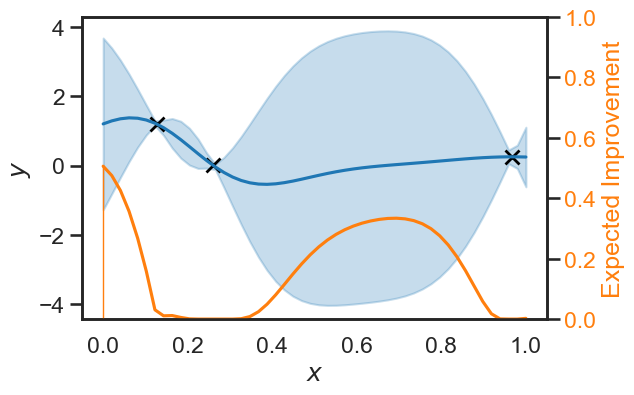

In [9]:
def ei(m, sigma, ymax, psi=0.):
    u = (m - ymax) / sigma
    ei = sigma * (u * stats.norm.cdf(u) + stats.norm.pdf(u))
    ei[sigma <= 0.] = 0.
    return ei

af_values = ei(m, sigma, Y.max())
idx = np.argmax(af_values)
af_max = af_values[idx]
next_x = x[idx]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x, m)
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
ax2 = ax.twinx()
ax2.plot(x, af_values, color=sns.color_palette()[1])
plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
ax2.set_ylabel('Expected Improvement', color=sns.color_palette()[1])
ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)
ax2.set_ylim(0, 1)

## The Sequential Information Acquisition Algorithm

Now that we have three different acquisition functions, let's implement the sequential information acquisition algorithm:

In [10]:
def maximize(f, gpr, X_design, alpha=ei, psi=0., max_it=6):
    """
    Optimize f using a limited number of evaluations.
    
    :param f:        The function to optimize.
    :param gpr:      A Gaussian process model to use for representing our state of knowldege.
    :param X_design: The set of candidate points for identifying the maximum.
    :param alpha:    The acquisition function.
    :param psi:      The parameter value for the acquisition function (not used for EI).
    :param max_it:   The maximum number of iterations.
    """
    af_all = []
    for count in range(max_it):
        m, sigma2 = gpr.predict(X_design)
        sigma = np.sqrt(sigma2)
        l = m - 1.96 * sigma
        u = m + 1.96 * sigma
        af_values = alpha(m, sigma, gpr.Y.max(), psi=psi)
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        y = np.vstack([gpr.Y, [f(X_design[i, :])]])
        gpr.set_XY(X, y)
        # Uncomment the following to optimize the hyper-parameters
        # gpr.optimize()
        af_all.append(af_values[i])
        fig, ax = plt.subplots(dpi=100)
        ax.plot(gpr.X, gpr.Y, 'kx', markersize=10, markeredgewidth=2)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.plot(x, m)
        ax.fill_between(X_design.flatten(), l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
        ax2 = ax.twinx()
        ax2.plot(X_design, af_values, color=sns.color_palette()[1])
        plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
        ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
        ax2.plot(X_design[i, :] * np.ones(100), np.linspace(0, af_values[i], 100), color=sns.color_palette()[1],
                 linewidth=1)
    return af_all

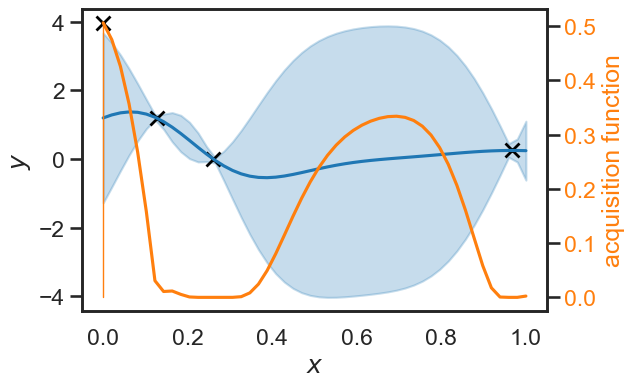

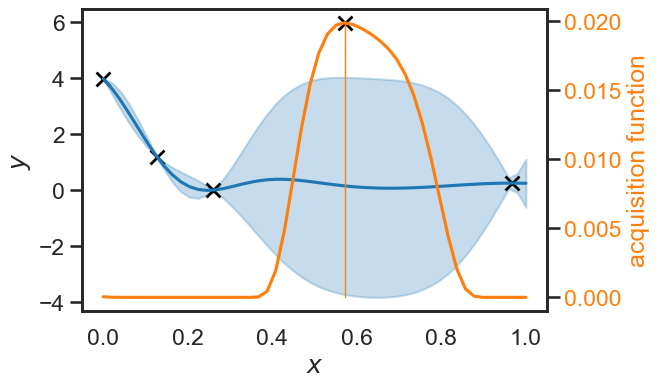

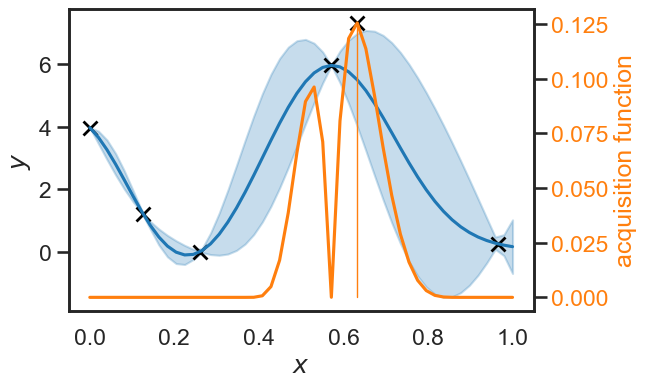

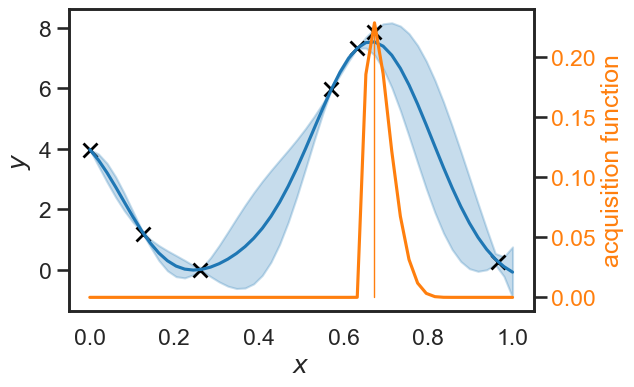

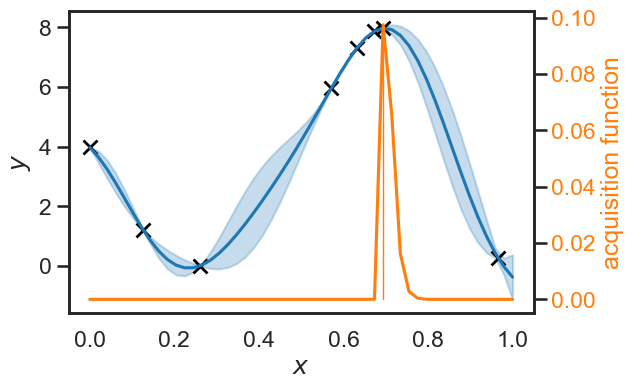

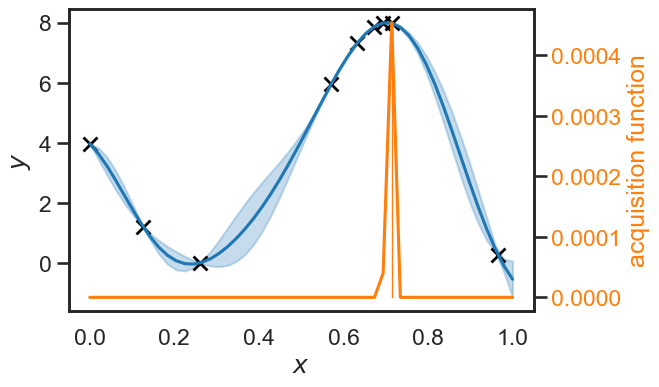

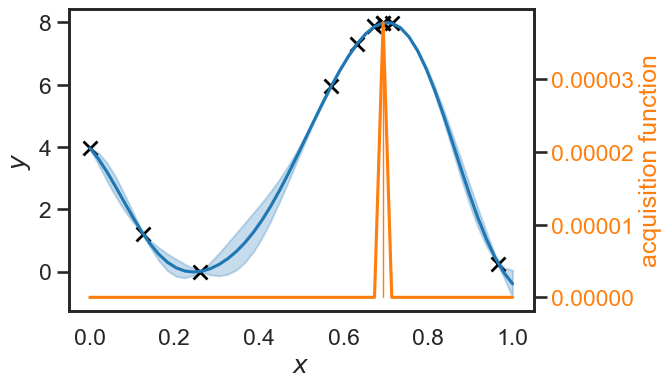

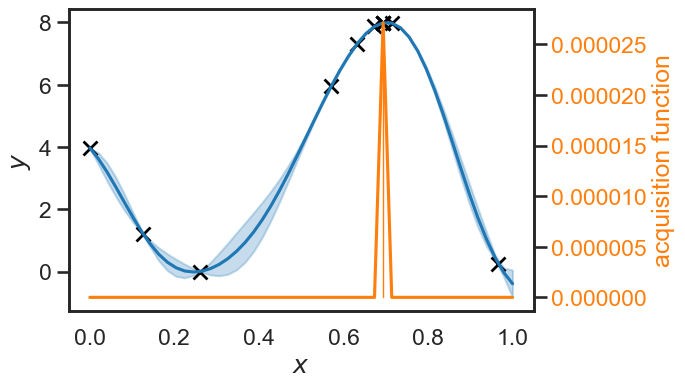

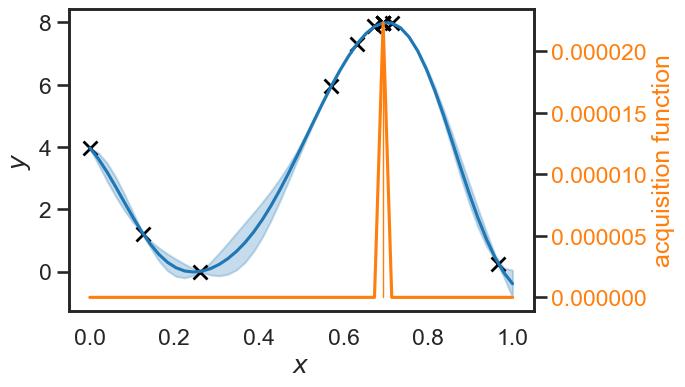

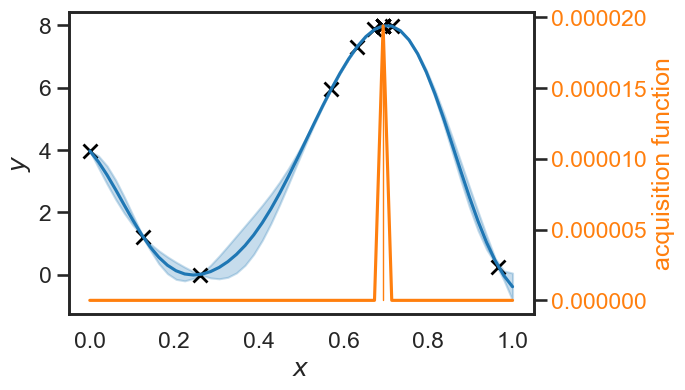

In [11]:
# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(1e-16)

# Run the algorithm
af_all = maximize(f, gpr, x[:, None], alpha=ei, psi=0., max_it=10)

Text(0, 0.5, 'Max inf. acq. value $a_n(\\mathbf{x}_{n+1})$')

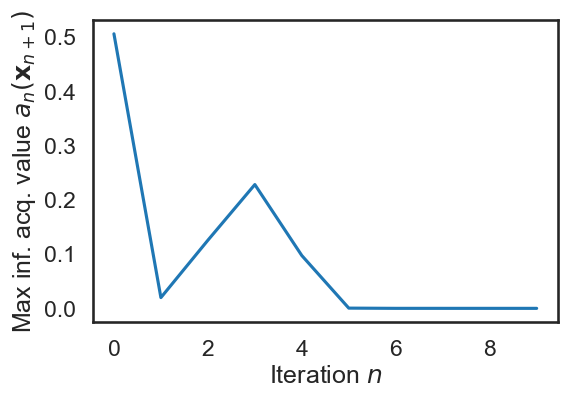

In [12]:
# Plot the maximum information acquisition added at each iteration
fig, ax = plt.subplots(dpi=100)
ax.plot(af_all)
ax.set_xlabel('Iteration $n$')
ax.set_ylabel('Max inf. acq. value $a_n(\mathbf{x}_{n+1})$')

### Questions
+ Rerun the main algorithm for EI by optimizing the hyper-parameters.
+ Repeat the main algorithm using POI for a $\psi$ that exploits. Does the method converge?
+ Repeat the main algorithm using POI for a $\psi$ that explores. Does the method converge?
+ Repeat the main algorithm using MUI for a $\psi$ that exploits. Does the method converge?
+ Repeat the main algorithm using MUI for a $\psi$ that explores. Does the method converge?
+ Go to the [GPyOpt tutorial](http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/GPyOpt_reference_manual.ipynb). Use it to solve our problem using EI and plot the convergence diagnostics. Then do their 2D problem.

## Quantifying our Epistemic Uncertainty About the Maximum

Imagine that you have observed data $\mathcal{D}_n$.
How certain are you about the location of the maximum?
If $n$ is small, you can't be too confident?
How do you quantify this epistemic uncertainty?
Notice that the maximum and the location of the maximum are *operators* acting on $f$:
$$
f^* := \max[f] := \max_{\mathbf{x}} f(\mathbf{x}),
$$
and
$$
\mathbf{x}^* := \mathbf{X}^*[f] := \arg\max_{\mathbf{x}} f(\mathbf{x}),
$$
respectively.
So since, we are uncertain about $f$, we will be uncertain about $f^*$ and $\mathbf{x}^*$.
In particular, we would like to somehow quantify the joint probability density $p(\mathbf{x}^*, f^*|\mathcal{D}_n)$.
Here is what is the formal answer:
$$
p(\mathbf{x}^*, f^*|\mathcal{D}_n) = \int \delta(\mathbf{x}^* - \mathbf{X}^*[f])\delta(f^*-\max[f])p(f(\cdot)|\mathcal{D}_n)df(\cdot).
$$
Of course, this is not technically correct because you cannot integrate over a function in this way.
The correct way to write this mathematically is to use conditional expectations:
$$
p(\mathbf{x}^*, f^*|\mathcal{D}_n) = \mathbb{E}\left[\delta(\mathbf{x}^* - \mathbf{X}^*[f])\delta(f^*-\max[f])|\mathcal{D}_n\right],
$$
where the expectation is taken over $f(\cdot)$ conditional on $\mathcal{D}_n$.
In any case, there are two questions:
+ What does this actually mean?
+ How do you compute it?

First, what does it actually mean?
To understand this you need to pay attention to the delta function.
Take for example $\delta(f^* - \max[f])$. What does it do?
Well, it just hits a counter whenever $\max[f]$ matches $f^*$ exactly as you take the expectation over $f(\cdot)$.

Second, how do you compute it?
The simplest way to do this is through sampling.
You basically just sample functions from $p(f(\cdot)|\mathcal{D}_n)$ and you find their maximum the location of the maximum.
Of course, you cannot really sample a function.
You sample the *function values* at a finite, but dense, number of input points and you find the maximum amongst these points.
Once you get these samples, you just look at their histogram.

Ok, let's do it for our working example:

In [13]:
def plot_max_and_argmax(gpr, X_design, n_samples=1000):
    """
    Plots histograms of the max and argmax of the function represented by the model gpr.
    It takes ``n_samples`` samples from the posterior to do that evaluated at ``X_design``.
    """
    f_samples = gpr.posterior_samples_f(X_design, size=n_samples)[:, 0, :]
    max_f_samples = np.max(f_samples, axis=0)
    x_star_samples = X_design[np.argmax(f_samples, axis=0), 0]
    fig, ax = plt.subplots(dpi=100)
    ax.hist(max_f_samples, density=True, alpha=0.25)
    ax.set_xlabel('$f^*$')
    ax.set_ylabel('$p(f^*|\mathcal{D}_n)$')
    fig, ax = plt.subplots(dpi=100)
    ax.hist(x_star_samples, density=True, alpha=0.25)
    ax.set_xlabel('$x^*$')
    ax.set_ylabel('$p(x^*|\mathcal{D}_n)$')
    return fig

In [14]:
gpr.set_XY(X[:, None], Y[:, None])

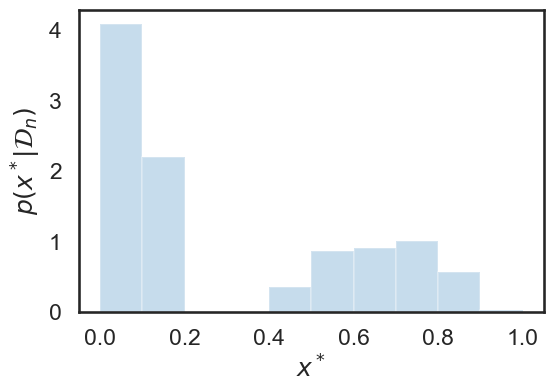

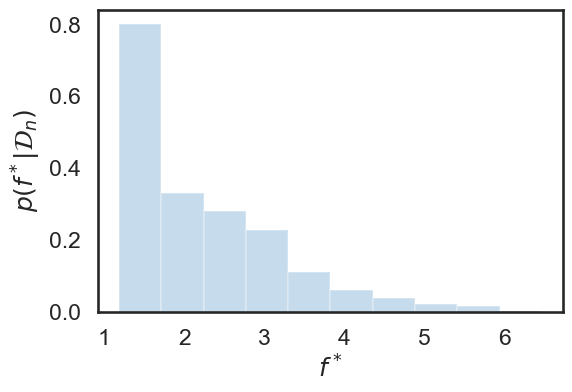

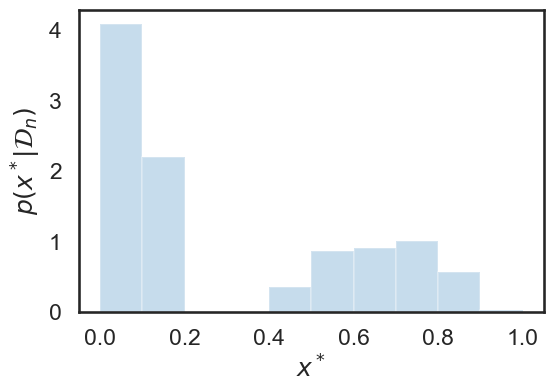

In [15]:
plot_max_and_argmax(gpr, x[:, None])

Let's put this functionality to our maximization algorithm:

In [16]:
def maximize(f, gpr, X_design, alpha=ei, psi=0., max_it=6, plot_epistemic=True):
    """
    Optimize f using a limited number of evaluations.
    
    :param f:        The function to optimize.
    :param gpr:      A Gaussian process model to use for representing our state of knowldege.
    :param X_design: The set of candidate points for identifying the maximum.
    :param alpha:    The acquisition function.
    :param psi:      The parameter value for the acquisition function (not used for EI).
    :param max_it:   The maximum number of iterations.
    """
    af_all = []
    for count in range(max_it):
        m, sigma2 = gpr.predict(X_design)
        sigma = np.sqrt(sigma2)
        l = m - 1.96 * sigma
        u = m + 1.96 * sigma
        af_values = alpha(m, sigma, gpr.Y.max(), psi=psi)
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        y = np.vstack([gpr.Y, [f(X_design[i, :])]])
        gpr.set_XY(X, y)
        # Uncomment the following to optimize the hyper-parameters
        # gpr.optimize()
        af_all.append(af_values[i])
        fig, ax = plt.subplots(dpi=100)
        ax.plot(gpr.X, gpr.Y, 'kx', markersize=10, markeredgewidth=2)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.plot(x, m)
        ax.fill_between(X_design.flatten(), l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
        ax2 = ax.twinx()
        ax2.plot(X_design, af_values, color=sns.color_palette()[1])
        plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
        ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
        ax2.plot(X_design[i, :] * np.ones(100), np.linspace(0, af_values[i], 100), color=sns.color_palette()[1],
                 linewidth=1)
        if plot_epistemic:
            fig = plot_max_and_argmax(gpr, X_design)
    return af_all

 /Users/iliasbilionis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /Users/iliasbilionis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /Users/iliasbilionis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memor

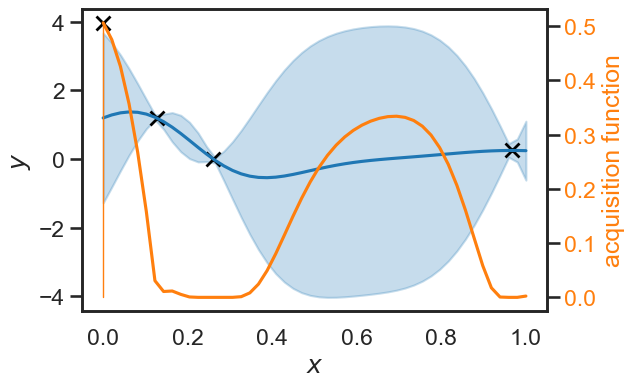

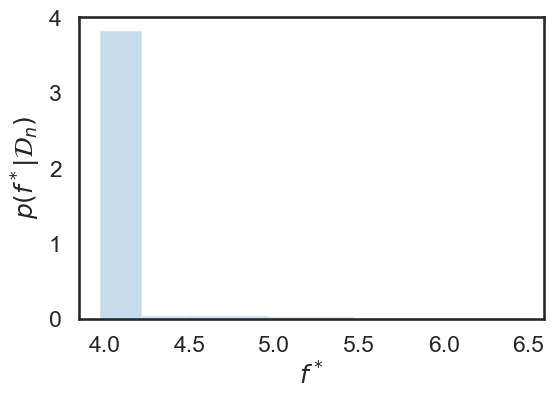

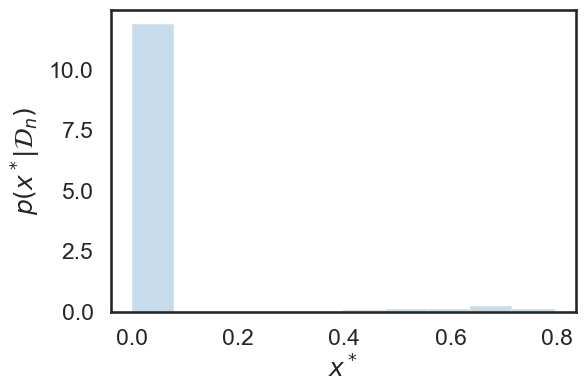

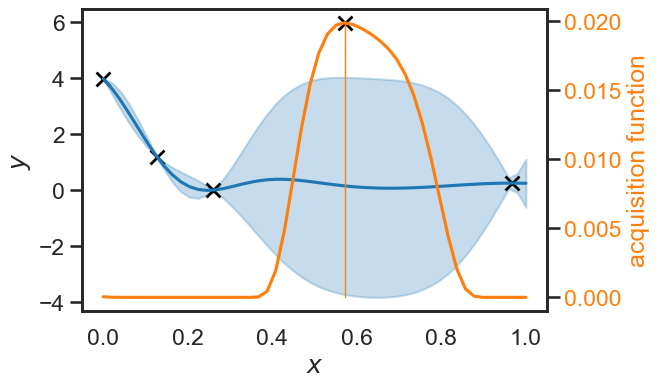

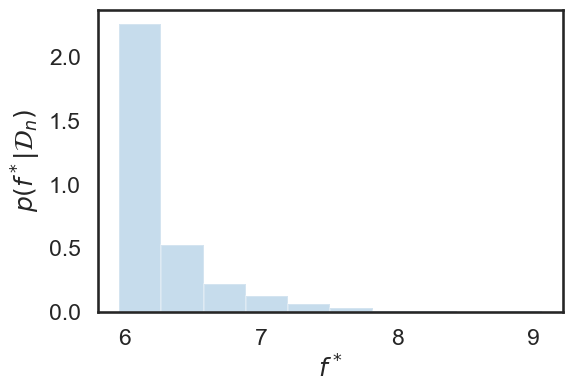

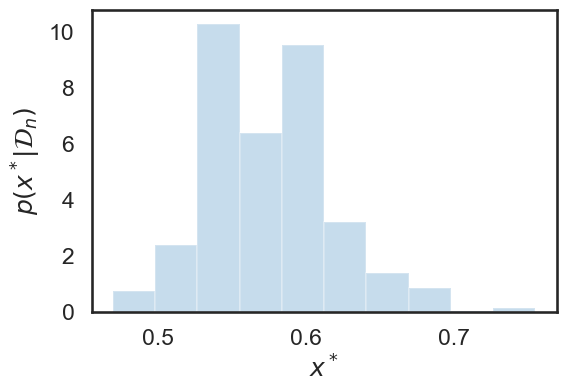

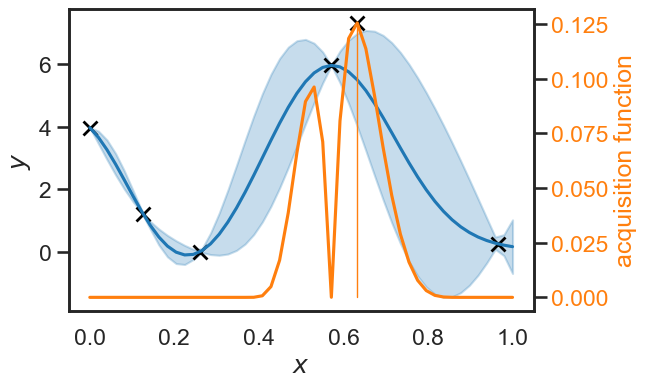

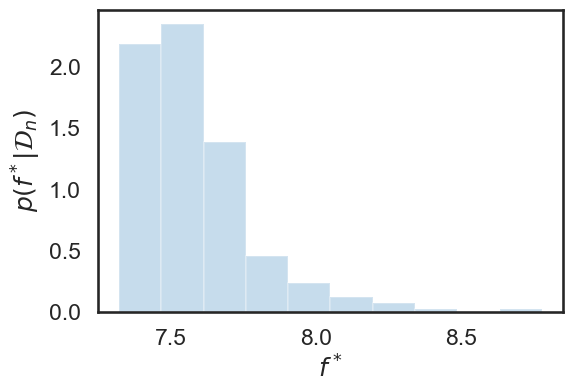

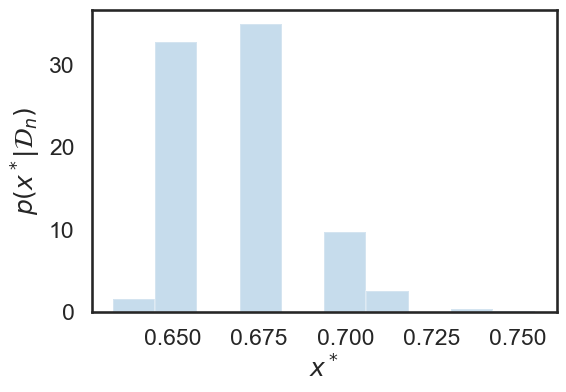

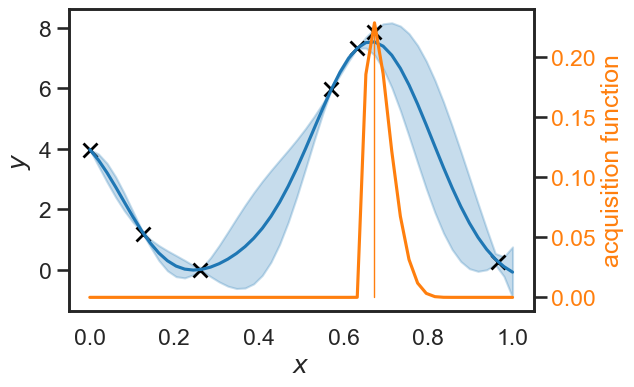

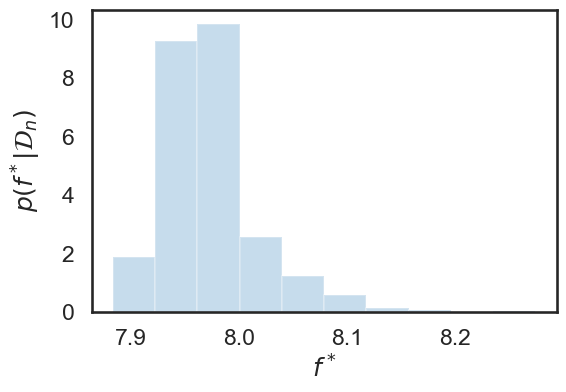

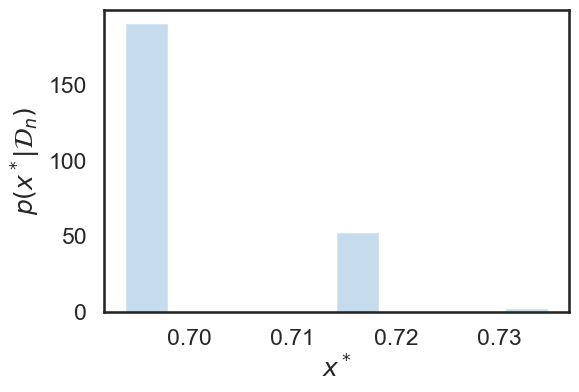

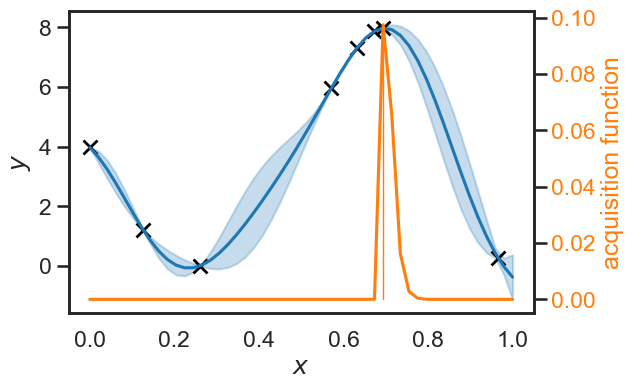

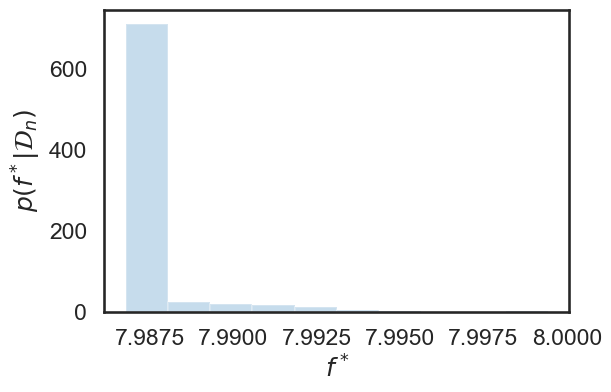

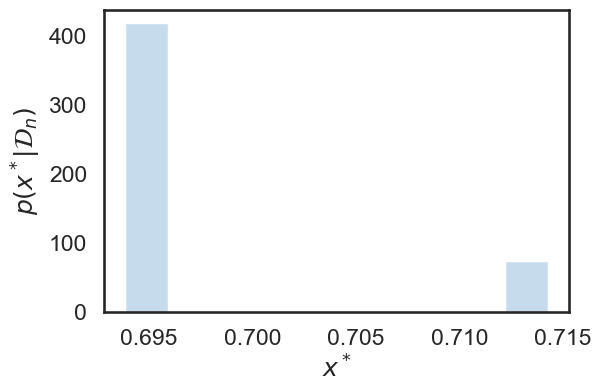

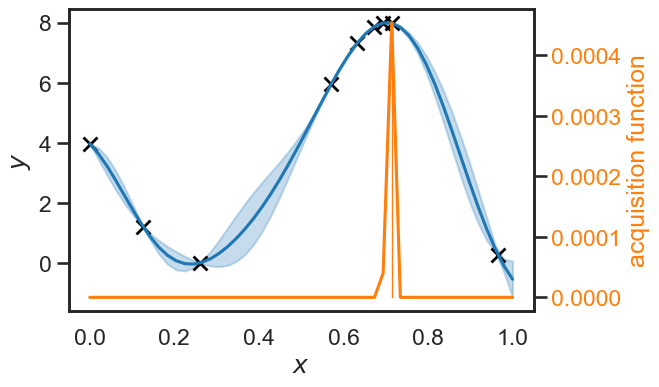

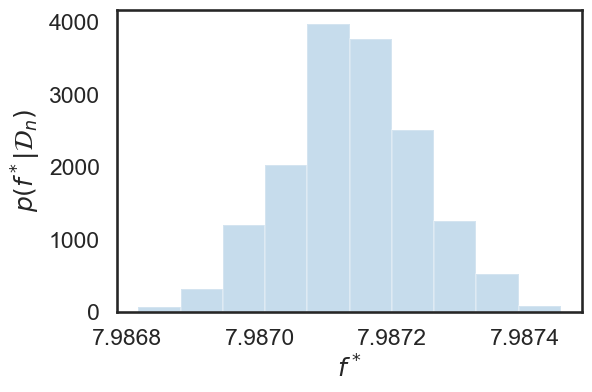

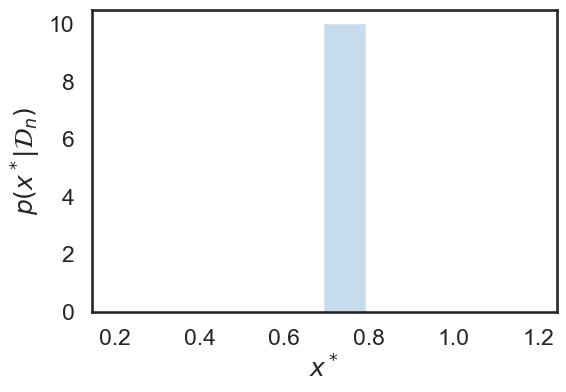

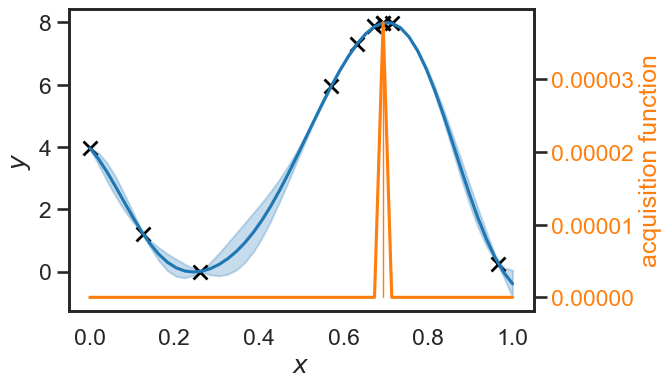

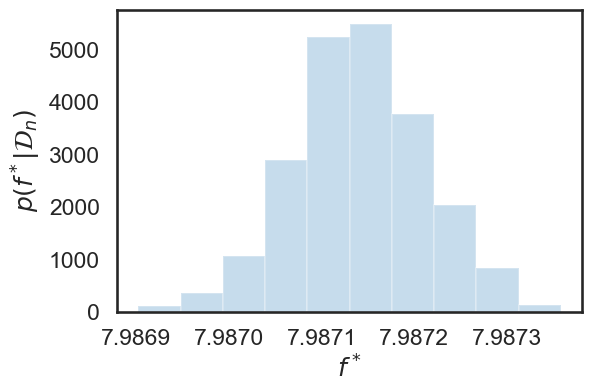

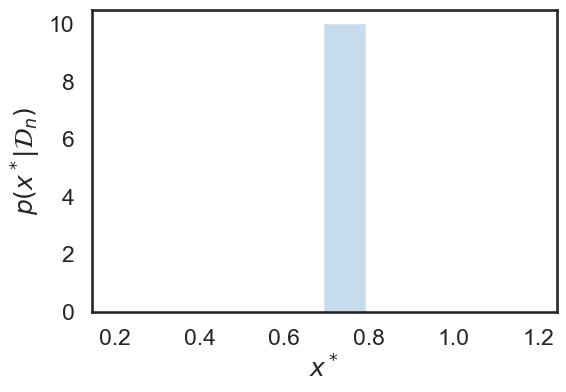

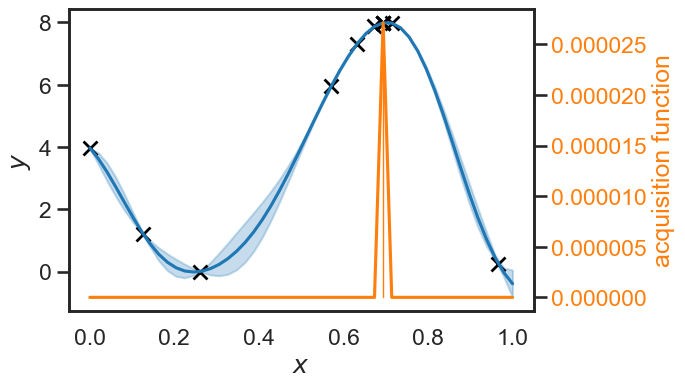

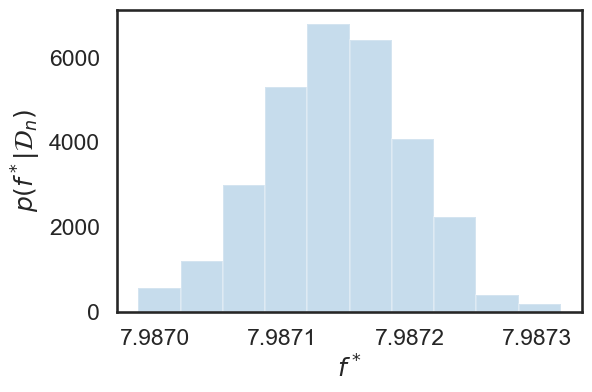

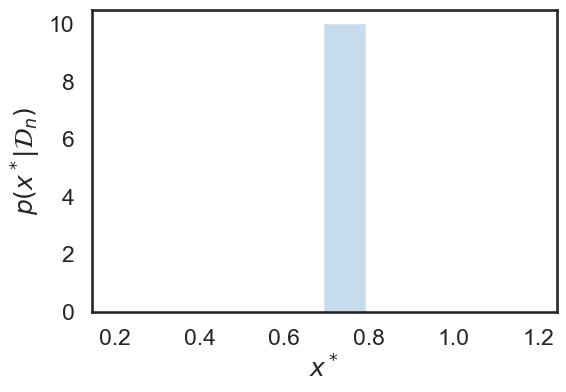

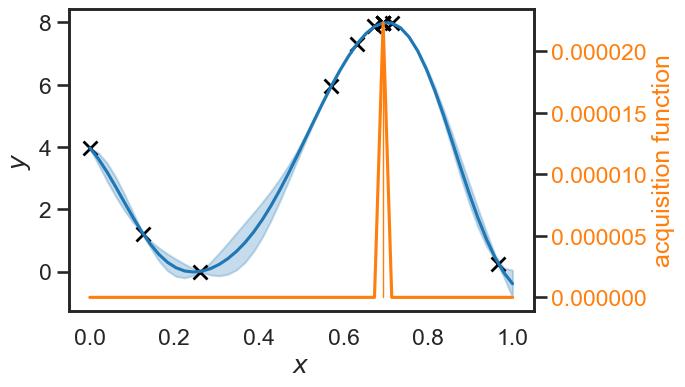

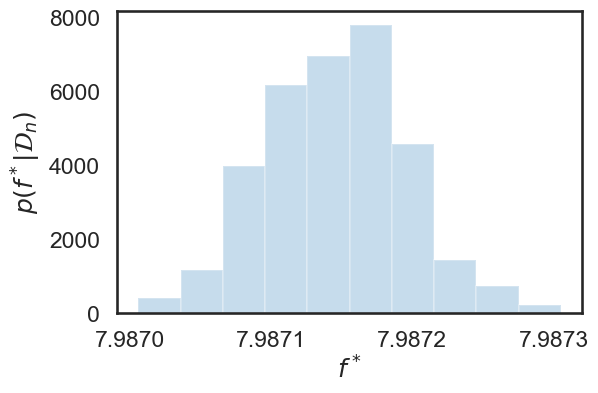

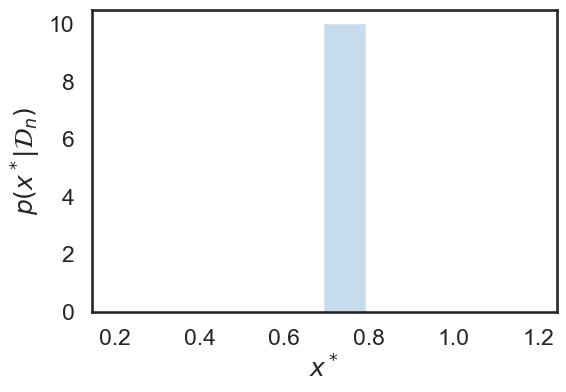

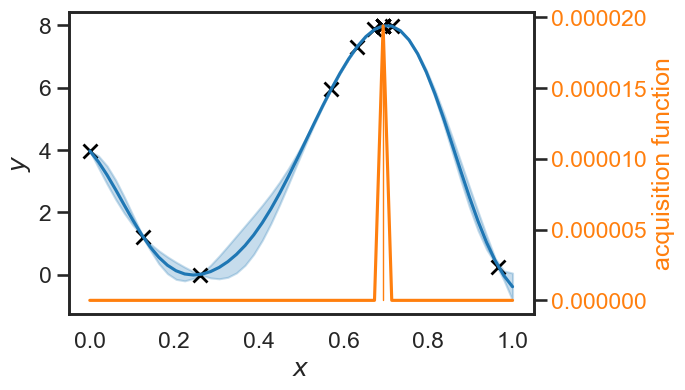

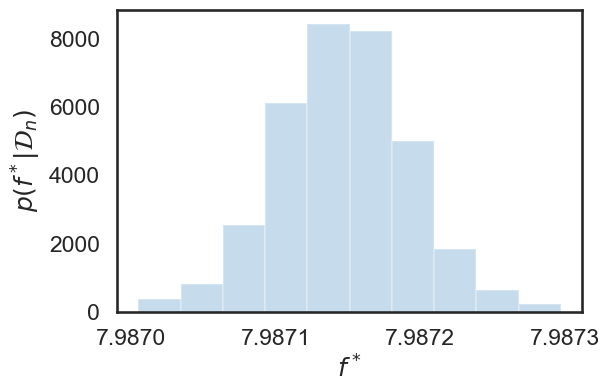

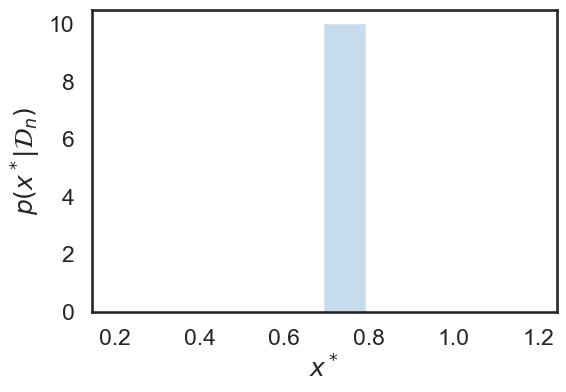

In [17]:
# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(1e-16)

# Run the algorithm
af_all = maximize(f, gpr, x[:, None], alpha=ei, psi=0., max_it=10)

## Optimizing Noisy Functions

The optimization of noisy functions is relevant when you are dealing with experimentally measured objectives.
In such a scenario, you do not observe $f(\mathbf{x})$, but a noisy version of it.
Here is a prototypical scenario of an experimentally measured objective.
Let $\xi$ be all the variables that affect the objective and assume that they are distributed in a way, not necessarily known to you:
$$
\xi \sim p(\xi).
$$
The you setup your experiment using a design $\mathbf{x}$ and you measure:
$$
y = g(\mathbf{x}, \xi).
$$
Let's assume now, that you would like to maximize the expectation of this function, i.e., you want to maximize
$$
f(\mathbf{x}) = \mathbb{E}_\xi[g(\mathbf{x},\xi)].
$$
The expectation here is over the experimental noise.

A naïve way of solving this problem is to approximate the expectation using sample averaging.
That is, at each $\mathbf{x}$ you do many experiments instead of just one.
If your experiments are not very expensive, you may just do that.
Then any of the algorithms above would work in your problem.

So, what do you do when you cannot get rid of the noise?
Well, this is an open problem.
But here is a quick and dirty solution which may work in many cases.
First, use GPR to approximate $f(\mathbf{x})$ using noisy measurements:
$$
y_i = g(\mathbf{x},\xi_i),
$$
for $i=1,\dots,n$. 
Note that here you do not necessarily have to observe the $\xi$'s.
You can assume that they are hidden. If you do observe them, you can exploit this fact.
But, for now, let's assume that you don't observe them.
If you don't observe them you need to somehow model their effect.
The easier thing to do is to assume that their effect is additive, zero mean, and Gaussian.
That is, we just assume that:
$$
y_i = f(\mathbf{x}_i) + \epsilon_i,
$$
where $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$, where $\sigma^2$ is to be determined.
Of course, this is, in general, not the right assumption for the noise.
It is, however, the easiest thing to do.
When we do this, we can just use GPR to find our posterior state of knowledge about $f(\cdot)$ and any hyperparameters).
We will be just using a MAP estimate for the hyperparameters.

The posterior GP conditioned on the observed data is given by the usual formulas:
$$
f(\cdot)|\mathcal{D}_n \sim \operatorname{GP}(m_n(\cdot), k_n(\cdot,\cdot)).
$$
Since we will be doing sequential experiment design, we are also going to need the point-predictive distribution for the measurement $y$ at a hypothetical $\mathbf{x}$.
It is:
$$
p(y|\mathbf{x},\mathcal{D}_n) = \mathcal{N}(y|m_n(\mathbf{x}), \sigma_n^2(\mathbf{x}) + \sigma^2),
$$
where $\sigma_n^2(\mathbf{x}) = k_n(\mathbf{x},\mathbf{x})$, i.e., the posterior variance for $f(\mathbf{x})$.
We now have all the ingredients to modify the information acquisition functions we had above for the noisy cases.

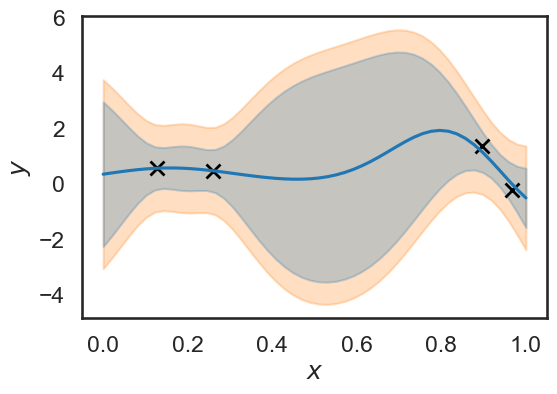

In [18]:
# As a working example let's generate data with noise
np.random.seed(123456) # For reproducibility
# The noise
sigma_noise = 0.4
# Here is a noisy function
def g(x):
    return f(x) + sigma_noise * np.random.randn(x.shape[0])

n_init = 4
X = np.random.rand(n_init) # In 1D you don't have to use LHS
Y = g(X)
# The kernel we use
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
# Assuming that we know the measurement noise (optimize otherwise, but you will need some data)
gpr.likelihood.variance.constrain_fixed(sigma_noise ** 2)
# You can evaluate the predictive distribution anywhere:
mn, v = gpr.predict(x[:, None])
sigman2 = v - sigma_noise ** 2
# And you can visualize the results as follows
# Standard deviation
sigman = np.sqrt(sigman2)
# Lower quantile
l = mn - 1.96 * sigman
u = mn + 1.96 * sigman
fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x, mn)
ax.fill_between(x, l.flatten() - 2.0 * sigma_noise, u.flatten() + 2.0 * sigma_noise, color=sns.color_palette()[1], alpha=0.25);
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25);

## Maximum upper interval with noise

The maximum upper interval remains the same:
$$
a_n(\mathbf{x}) = \mu_n(\mathbf{x}) + \psi \sigma_n(\mathbf{x}),
$$
for some $\psi \ge 0$.
Just make sure you don't add the $\sigma^2$ term in the variance.
Of course, we need to modify the way we grab the variance from ``GPy`` for this.
Here it is:

In [19]:
def plot_mui_w_noise(psi=0.):
    fig, ax = plt.subplots(dpi=100)
    ax.set_title('$\psi={0:1.2f}$'.format(psi))
    ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.plot(x, mn)
    ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
    af_values = mui(mn, sigman, Y.max(), psi)
    next_id = np.argmax(af_values)
    next_x = x[next_id]
    af_max = af_values[next_id]
    ax2 = ax.twinx()
    ax2.plot(x, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel('Maximum Upper Interval', color=sns.color_palette()[1])
    plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
    ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)

interact_manual(plot_mui_w_noise, psi=(0., 4., 0.001));

interactive(children=(FloatSlider(value=0.0, description='psi', max=4.0, step=0.001), Button(description='Run …

## Probability of improvement with noise

We need to make some modifications to the probability of improvement.
First, we cannot just use the $y_n^*$ as the maximum of the $y_i$'s, because they are noisy.
Instead, we are looking at the predictive mean of the GP, $m_n(\mathbf{x}_i)$, at the corresponding inputs, $\mathbf{x}_i$, and we find their maximum.
So, define:
$$
m_n^* = \max_{1\le i\le n}m_n(\mathbf{x}_i).
$$
Essentially, instead of finding the maximum of the noisy observations, we are smoothing with the predictive mean of the GP and find the maximum of the smoothed versions.
The rest is similar.
The acquisition function is defined by:
$$
a_n(\mathbf{x}) = \mathbb{P}[f(\mathbf{x}) > m_n^* + \psi | \mathbf{x}, \mathcal{D}_n].
$$
We read "$a_n(\mathbf{x})$" is the probability that we observe at $x$ a $y$ that is greater than the currently observed maximum $y_n^*$ by at least $\psi>0$.
The good thing is that it is possible to get an analytical answer because our point predictive distribution is Gaussian.
In particular, we get:
$$
\begin{align}
a_n(\mathbf{x}) &=& \mathbb{P}[f(\mathbf{x}) > m_n^* + \psi | \mathbf{x}, \mathcal{D}_n]\\
&=& \mathbb{P}\left[\frac{f(\mathbf{x}) - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} > \frac{m_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \Big| \mathbf{x}, \mathcal{D}_n\right]\\
&=& \dots\\
&=& \Phi\left(\frac{\mu_n(\mathbf{x}) - m_n^* - \psi}{\sigma_n(\mathbf{x})} \right).
\end{align}
$$


In [20]:
# We just need to get the smoothed versions of the observed y's
y_smoothed = gpr.predict(X[:, None])[0]
# and then their maximum
mn_star = y_smoothed.max()

def plot_poi_w_noise(psi=0.):
    fig, ax = plt.subplots(dpi=100)
    ax.set_title('$\psi={0:1.2f}$'.format(psi))
    ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.plot(x, mn)
    ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
    af_values = poi(mn, sigman, mn_star, psi)
    next_id = np.argmax(af_values)
    next_x = x[next_id]
    af_max = af_values[next_id]
    ax2 = ax.twinx()
    ax2.plot(x, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel('Probability of Improvement', color=sns.color_palette()[1])
    plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
    ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)
    ax2.set_ylim(0, 1)

interact_manual(plot_poi_w_noise, psi=(0., 4., 0.001));

interactive(children=(FloatSlider(value=0.0, description='psi', max=4.0, step=0.001), Button(description='Run …

## Expected improvment with noise

The arguments here are as in the previous section about the probability of improvement.
Consider a hypothetical experiment at $\mathbf{x}$ and assume that you observed $y$.
How much improvement is that compared to your currently best observed point $m_n^*$.
It is:
$$
I_n(\mathbf{x}, f(\mathbf{x})) =
\begin{cases}
0,&\;\text{if}\;f(\mathbf{x}) \le m_n^*,\\
f(\mathbf{x}) - m_n^*,&\;\text{otherwise},
\end{cases}
$$
and this conditional of $y$, i.e., $f(\mathbf{x})$ is a random variable conditioned on $y$.
Taking the expectation over $y$ would give you:
$$
\operatorname{EI}_n(\mathbf{x}) = \frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\Phi\left(\frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\right)
+ \phi\left(\frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\right).
$$

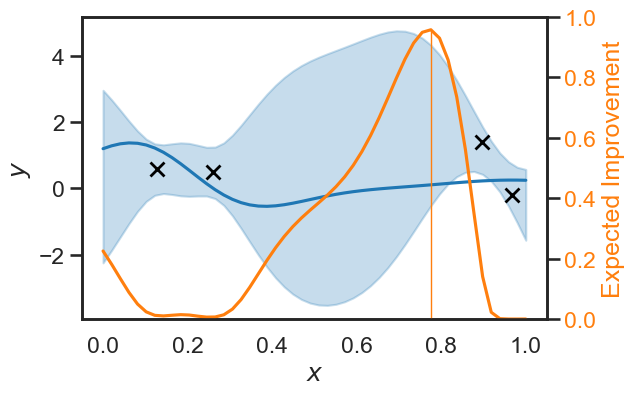

In [21]:
def ei(m, sigma, ymax, psi=0.):
    u = (m - ymax) / sigma
    ei = sigma * (u * stats.norm.cdf(u) + stats.norm.pdf(u))
    ei[sigma <= 0.] = 0.
    return ei

af_values = ei(mn, sigman, mn_star)
idx = np.argmax(af_values)
af_max = af_values[idx]
next_x = x[idx]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x, m)
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
ax2 = ax.twinx()
ax2.plot(x, af_values, color=sns.color_palette()[1])
plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
ax2.set_ylabel('Expected Improvement', color=sns.color_palette()[1])
ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)
ax2.set_ylim(0, 1);

Let's modify now our sequential information acquisition algorithm so that it works with noise:

In [22]:
def maximize_w_noise(g, gpr, X_design, alpha=ei, psi=0., max_it=6, plot_epistemic=True):
    """
    Optimize f using a limited number of evaluations.
    
    :param f:        The function to optimize.
    :param gpr:      A Gaussian process model to use for representing our state of knowldege.
    :param X_design: The set of candidate points for identifying the maximum.
    :param alpha:    The acquisition function.
    :param psi:      The parameter value for the acquisition function (not used for EI).
    :param max_it:   The maximum number of iterations.
    """
    af_all = []
    for count in range(max_it):
        mn, v = gpr.predict(X_design)
        sigman2 = v - gpr.likelihood.variance
        sigman = np.sqrt(sigman2)
        l = mn - 1.96 * sigman
        u = mn + 1.96 * sigman
        y_smoothed = gpr.predict(gpr.X)[0]
        mn_star = y_smoothed.max()
        af_values = alpha(mn, sigman, mn_star, psi=psi)
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        y = np.vstack([gpr.Y, [g(X_design[i, :])]])
        gpr.set_XY(X, y)
        # Uncomment the following to optimize the hyper-parameters
        # gpr.optimize()
        af_all.append(af_values[i])
        fig, ax = plt.subplots(dpi=100)
        ax.plot(gpr.X, gpr.Y, 'kx', markersize=10, markeredgewidth=2)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.plot(x, mn)
        ax.fill_between(X_design.flatten(), l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
        ax2 = ax.twinx()
        ax2.plot(X_design, af_values, color=sns.color_palette()[1])
        plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
        ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
        ax2.plot(X_design[i, :] * np.ones(100), np.linspace(0, af_values[i], 100), color=sns.color_palette()[1],
                 linewidth=1)
        if plot_epistemic:
            fig = plot_max_and_argmax(gpr, X_design)
    return af_all

 /Users/iliasbilionis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /Users/iliasbilionis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /Users/iliasbilionis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memor

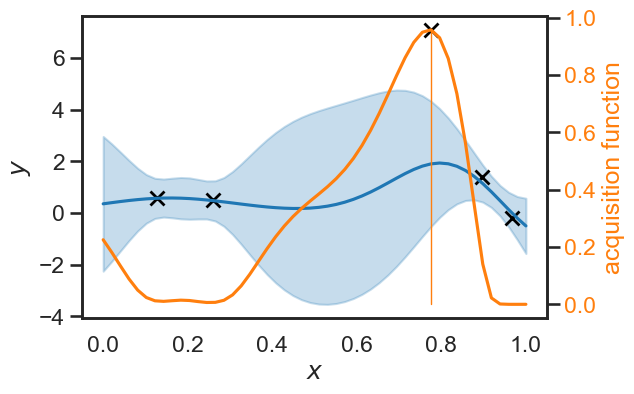

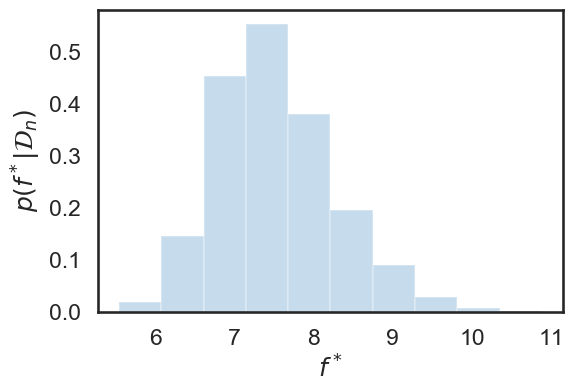

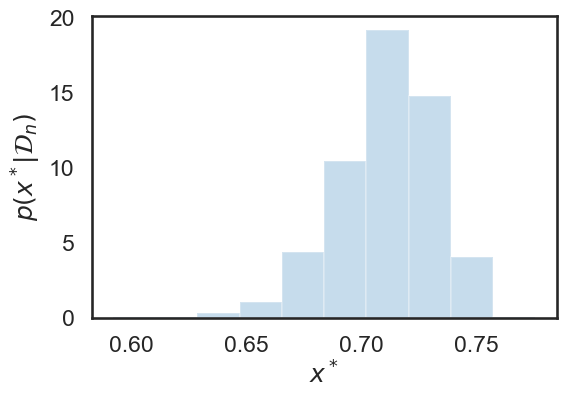

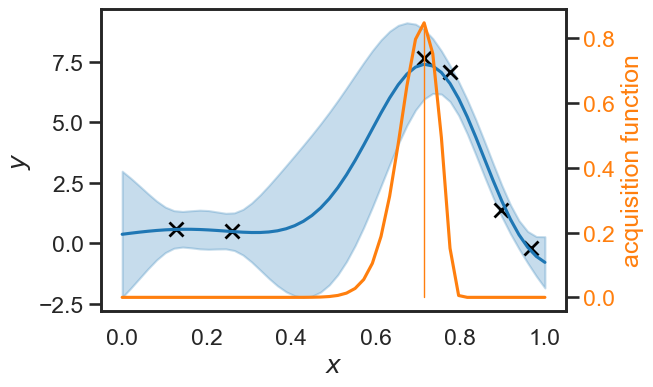

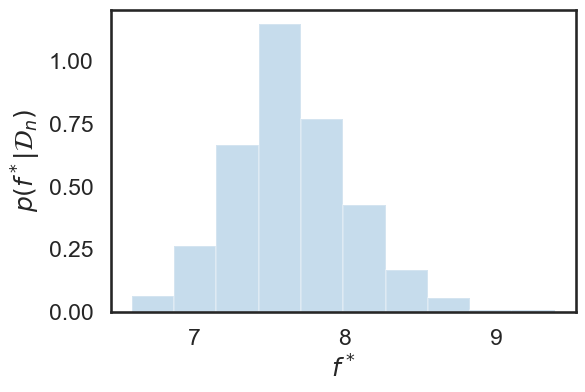

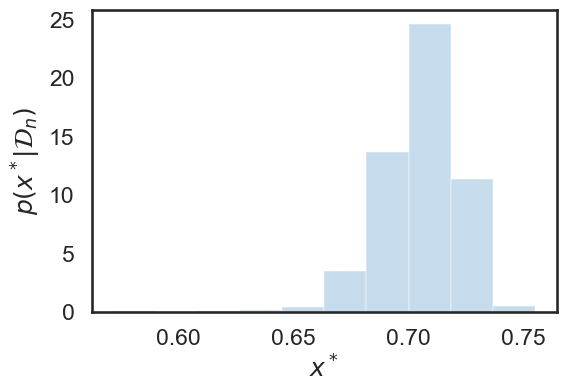

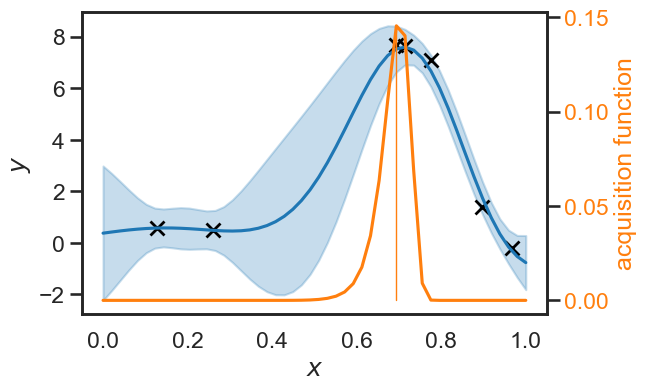

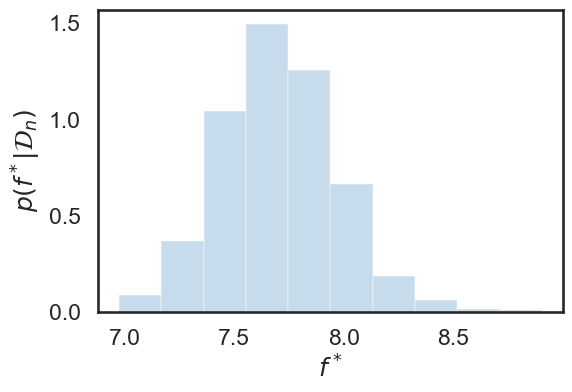

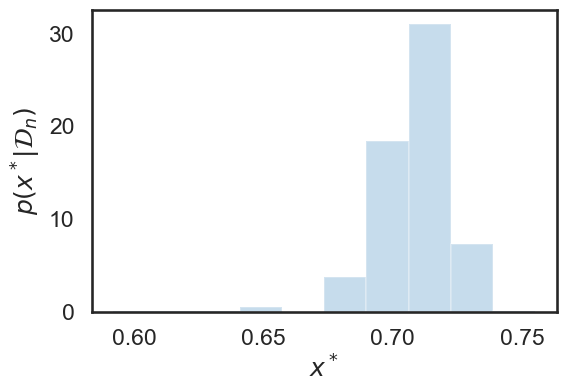

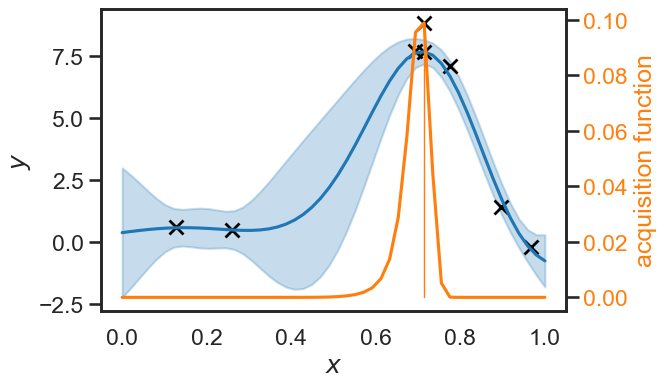

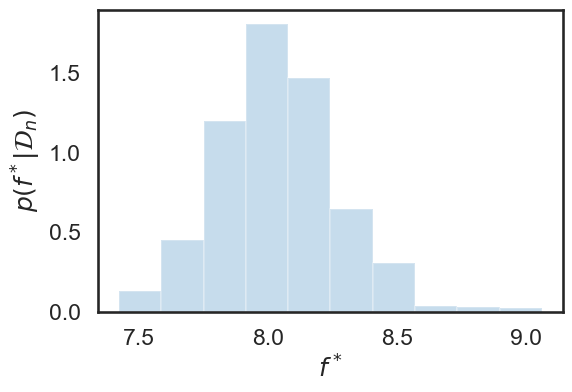

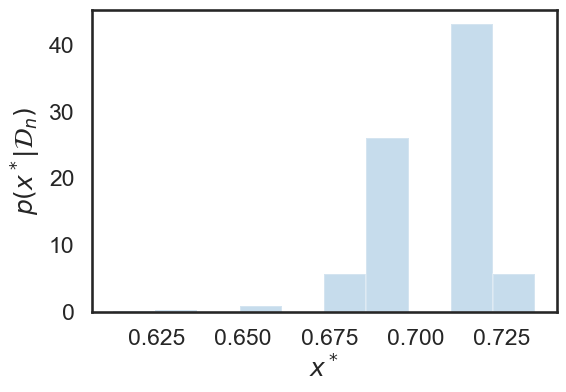

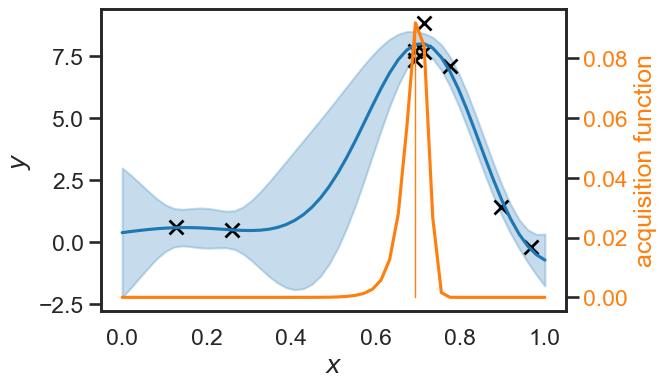

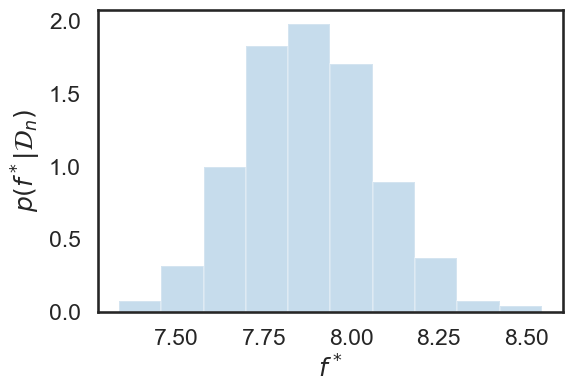

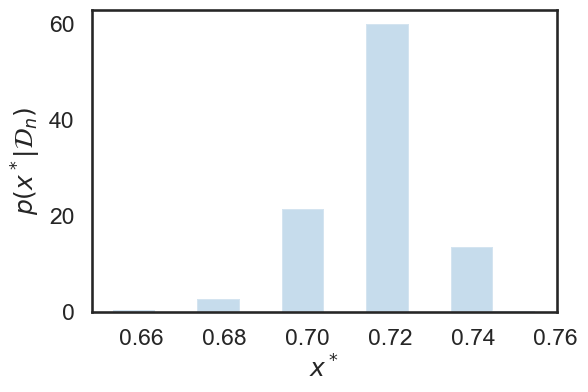

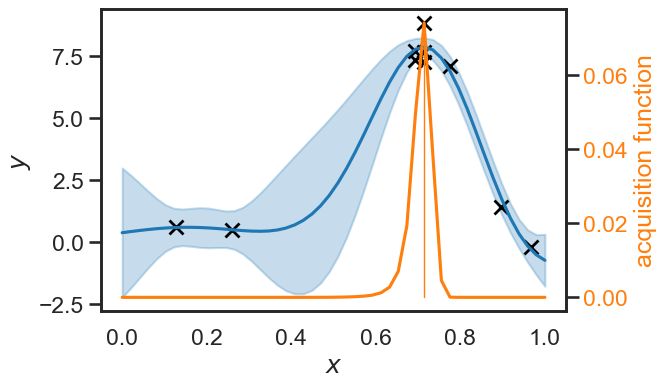

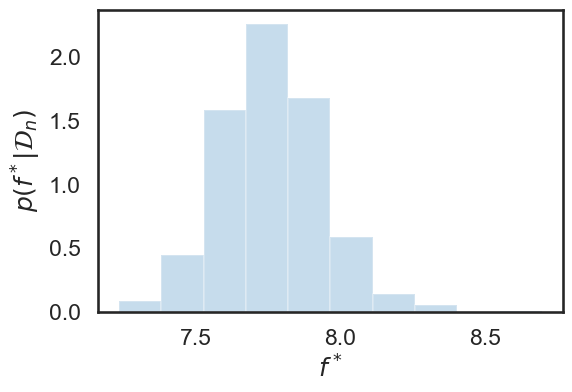

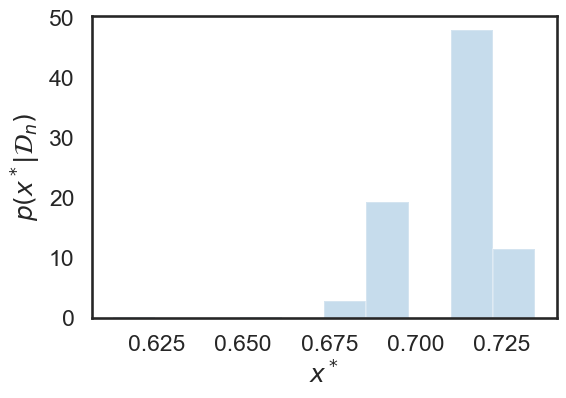

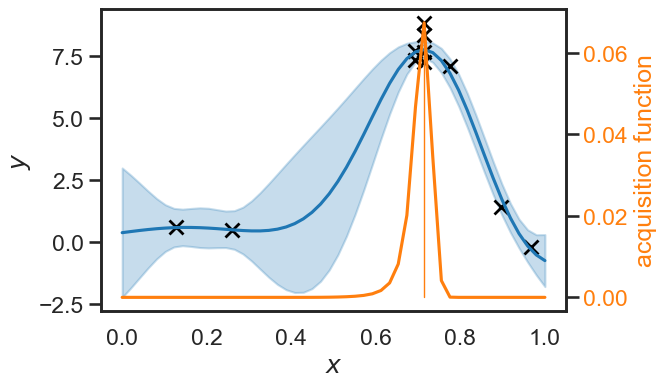

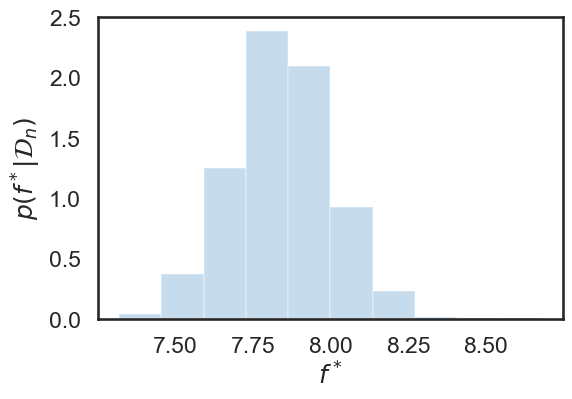

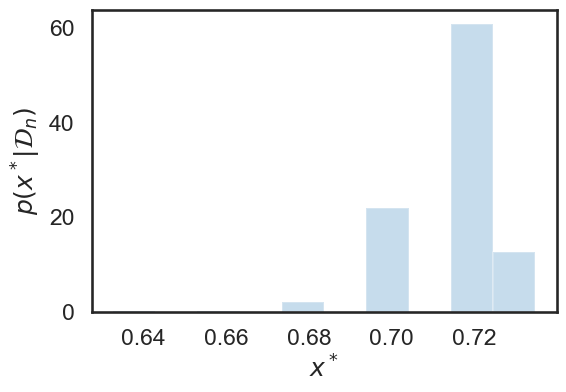

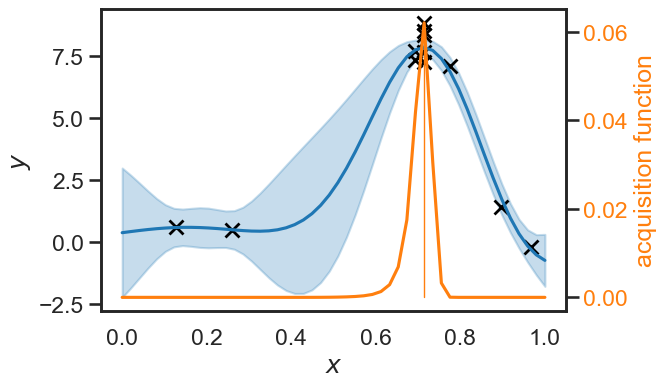

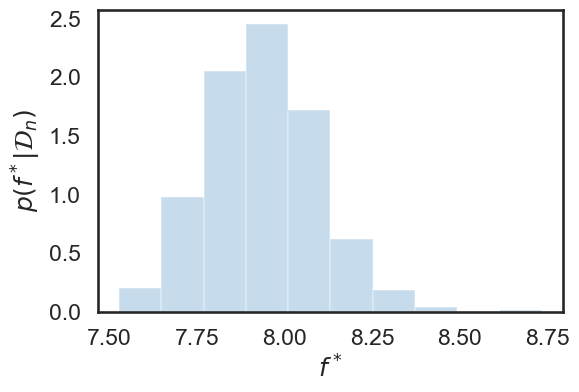

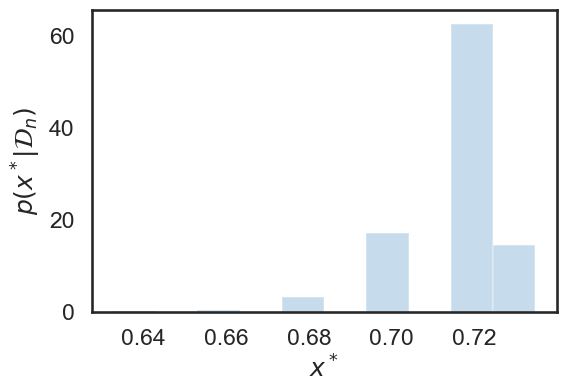

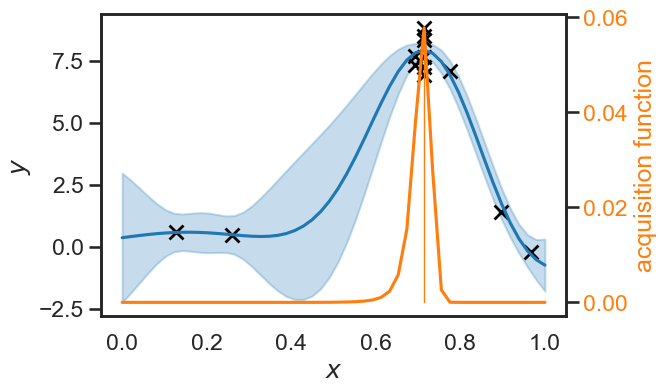

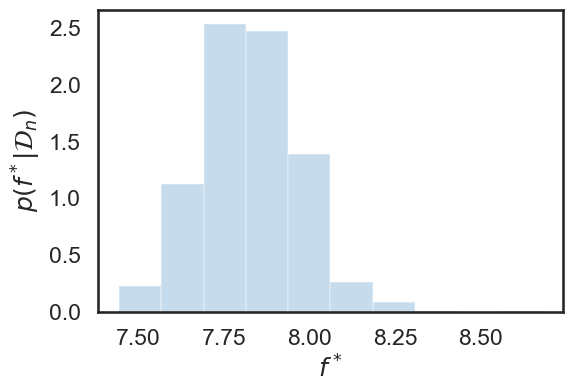

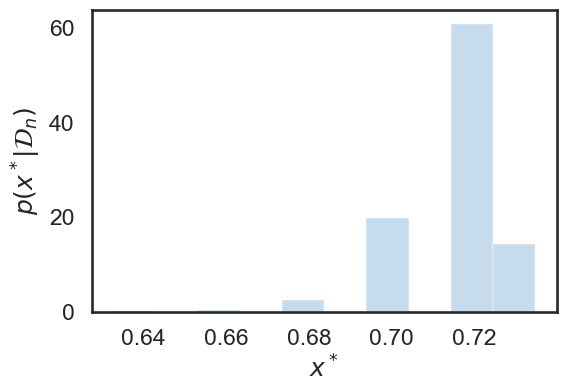

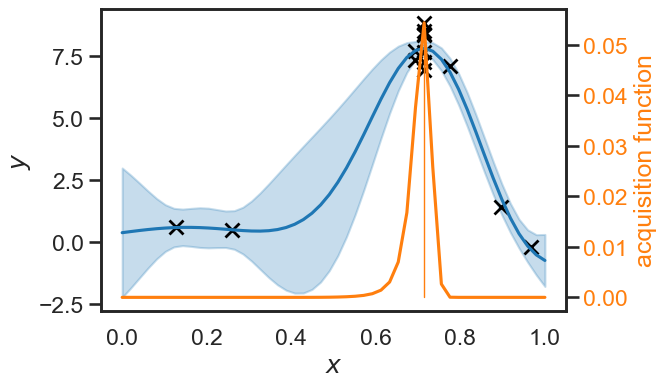

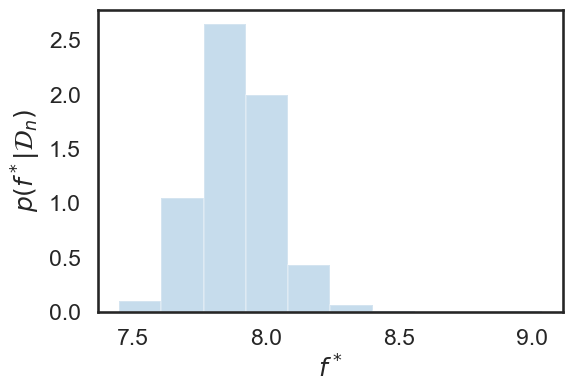

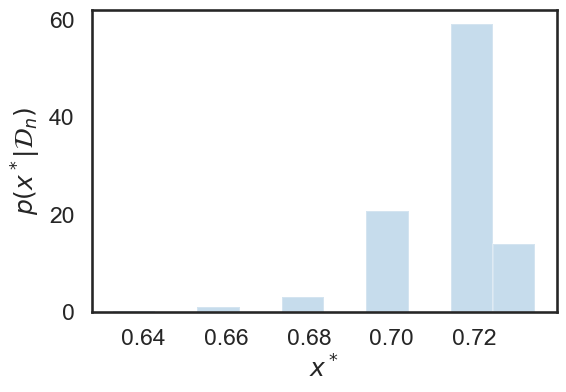

In [23]:
# As a working example let's generate data with noise
np.random.seed(123456) # For reproducibility
# The noise
sigma_noise = 0.4
# Here is a noisy function
def g(x):
    return f(x) + sigma_noise * np.random.randn(x.shape[0])

n_init = 4
X = np.random.rand(n_init) # In 1D you don't have to use LHS
Y = g(X)

# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(sigma_noise ** 2)
# Run the algorithm
af_all = maximize_w_noise(g, gpr, x[:, None], alpha=ei, psi=0., max_it=10)

## Questions

+ Rerun the algorithm above starting with 3 observations. Does the algorithm find the same local maximum?
If not, why?
+ Experiment with smaller noise. 
+ Experiment with larger noise.